In [1]:
!pip install kaggle
!mkdir .kaggle
from google.colab import files
files.upload()

mkdir: cannot create directory ‘.kaggle’: File exists


Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"shashanksubham","key":"824208661ba774dea08a2b5ed365f97f"}'}

In [2]:
import json
token = {"username":"shashanksubham","key":"824208661ba774dea08a2b5ed365f97f"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets list

- path is now set to: {/content}
ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31           1052  
shivan118/healthcare-analytics                         Healthcare Analytics                                2MB  2020-09-13 17:40:05            585  
Cornell-University/arxiv                               arXiv Dataset                                     885MB  2020-09-14 16:54:47           2847  
nipunarora8/age-gender-and-ethnicity-face-data-csv     AGE, GENDER AND ETHNICITY (FACE DATA) CSV          63MB  2020-09-02 13:46:38            337  
datatattle/covid-19-nlp-text-classification            Coronavirus tweets

In [4]:
!kaggle datasets download -d nikitarom/planets-dataset -p /content
!unzip \*.zip

planets-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import cv2
from PIL import Image
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import fbeta_score
import time
%matplotlib inline

pal = sns.color_palette()

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [63]:
df_train = pd.read_csv('/content/planet/planet/train_classes.csv')
df_test = pd.read_csv('/content/planet/planet/sample_submission.csv')

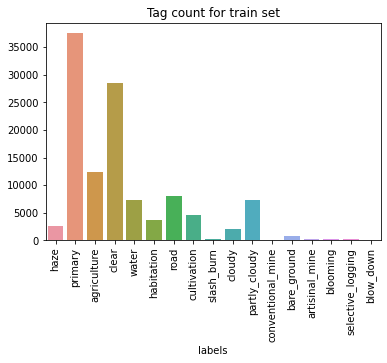

In [64]:
labels = df_train['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int) #dictionary containing each individual label
for l in labels:
    for l2 in l:
        counts[l2] += 1
        
        
tag_list=list(counts.keys()) 
y=list(counts.values())
sns.barplot(x=tag_list, y=y);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag count for train set');

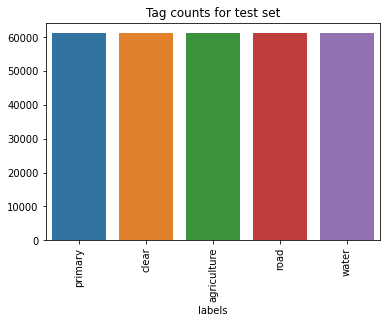

In [65]:
labels_test = df_test['tags'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts_test = defaultdict(int)
for l in labels_test:
    for l2 in l:
        counts_test[l2] += 1

tag_list_test=list(counts_test.keys()) 
test_count=list(counts_test.values())
sns.barplot(x=tag_list_test, y=test_count);
plt.xlabel('labels');
plt.xticks(rotation = 90);
plt.title('Tag counts for test set');

In [66]:
label_map = {i:j for j, i in enumerate(tag_list)}
label_map

{'agriculture': 2,
 'artisinal_mine': 13,
 'bare_ground': 12,
 'blooming': 14,
 'blow_down': 16,
 'clear': 3,
 'cloudy': 9,
 'conventional_mine': 11,
 'cultivation': 7,
 'habitation': 5,
 'haze': 0,
 'partly_cloudy': 10,
 'primary': 1,
 'road': 6,
 'selective_logging': 15,
 'slash_burn': 8,
 'water': 4}

In [67]:
# One hot encode the training labels. Convert the images into pixels and resize them
X_train, Y_train = [], []
for img, label in tqdm(df_train.values, miniters = 1000):
  target = np.zeros(17)
  for tag in label.split(' '):
    target[label_map[tag]]=1
  X_train.append(cv2.resize(cv2.imread('/content/planet/planet/train-jpg/{}.jpg'.format(img)), (64,64)))
  Y_train.append(target)

100%|██████████| 40479/40479 [01:04<00:00, 622.85it/s]


In [68]:
#converting tes images and resizing
X_test=[]
for img, label in tqdm(df_test[:40669].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/planet/planet/test-jpg/{}.jpg'.format(img)), (64,64)))
for img, label in tqdm(df_test[40669:].values, miniters = 1000):
  X_test.append(cv2.resize(cv2.imread('/content/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64,64)))
x_test = np.array(X_test, np.float16)/255

100%|██████████| 20522/20522 [00:32<00:00, 632.23it/s]


In [69]:
len(X_test), len(X_train), len(Y_train)

(61191, 40479, 40479)

In [70]:
import gc
gc.collect()

3338

In [71]:
#Change lists to numpy arrays and normalize
x_train = np.array(X_train, np.float16)/255
y_train = np.array(Y_train, np.uint8)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, shuffle = True, random_state = 1)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(32383, 64, 64, 3) (32383, 17) (8096, 64, 64, 3) (8096, 17)


In [72]:
#delete X_test, X_train, Y_train to free up space
del(X_test, X_train, Y_train)

In [73]:
yfull_test = []
yfull_train = []
X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_train, y_train, test_size = 0.2, random_state = 1)

In [74]:
import gc
gc.collect()

0

In [75]:
kfold_weights_path = os.path.join('', 'weights_kfold_' + '.h5')
model = Sequential()
model.add(BatchNormalization(input_shape=(64, 64,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
        
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

In [76]:
import gc
gc.collect()

0

In [77]:
epochs = 50
learn_rate = 0.0001
opt  = optimizers.Adam(lr=learn_rate)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0)]


model.fit(x = X_train_, y= Y_train_, validation_data=(X_val_, Y_val_),batch_size=128,verbose=2, epochs=epochs,callbacks=callbacks,shuffle=True)

p_val = model.predict(X_val_, batch_size = 32, verbose=2)
print(fbeta_score(Y_val_, np.array(p_val) > 0.2, beta=2, average='samples')) #Check the model performance on the validation set

p_train = model.predict(x_train, batch_size =128, verbose=2) #save the training predictions
yfull_train.append(p_train)
        
p_test = model.predict(x_test, batch_size = 128, verbose=2) #save the test predictions
yfull_test.append(p_test)

Epoch 1/50
203/203 - 6s - loss: 0.6421 - accuracy: 0.1064 - val_loss: 0.5959 - val_accuracy: 0.8644
Epoch 2/50
203/203 - 6s - loss: 0.4694 - accuracy: 0.1789 - val_loss: 0.3867 - val_accuracy: 0.8598
Epoch 3/50
203/203 - 6s - loss: 0.2890 - accuracy: 0.2821 - val_loss: 0.2468 - val_accuracy: 0.6569
Epoch 4/50
203/203 - 6s - loss: 0.2083 - accuracy: 0.3732 - val_loss: 0.1896 - val_accuracy: 0.2810
Epoch 5/50
203/203 - 6s - loss: 0.1781 - accuracy: 0.4254 - val_loss: 0.1719 - val_accuracy: 0.2798
Epoch 6/50
203/203 - 6s - loss: 0.1637 - accuracy: 0.4882 - val_loss: 0.1618 - val_accuracy: 0.2686
Epoch 7/50
203/203 - 6s - loss: 0.1545 - accuracy: 0.5278 - val_loss: 0.1583 - val_accuracy: 0.3665
Epoch 8/50
203/203 - 6s - loss: 0.1496 - accuracy: 0.5712 - val_loss: 0.1517 - val_accuracy: 0.3986
Epoch 9/50
203/203 - 6s - loss: 0.1446 - accuracy: 0.5801 - val_loss: 0.1408 - val_accuracy: 0.7088
Epoch 10/50
203/203 - 6s - loss: 0.1417 - accuracy: 0.6281 - val_loss: 0.1421 - val_accuracy: 0.4758

In [78]:
import gc
gc.collect()

18570

In [79]:
predictions = model.predict(x_test, batch_size = 32)
predictions

array([[1.5434076e-03, 9.9898845e-01, 8.9651635e-03, ..., 5.9693335e-03,
        8.6934381e-04, 6.6715165e-04],
       [1.3158658e-03, 9.9891686e-01, 2.0769931e-02, ..., 7.7160217e-02,
        1.1772787e-02, 7.5181378e-03],
       [6.7685451e-04, 9.9897230e-01, 5.5519298e-02, ..., 9.8957925e-04,
        4.5309350e-04, 8.8433747e-04],
       ...,
       [2.4326420e-03, 9.9797219e-01, 4.7106761e-02, ..., 2.2977032e-02,
        9.5367664e-03, 2.4474615e-03],
       [6.7550555e-02, 7.6319121e-02, 4.6057911e-03, ..., 3.3227811e-04,
        1.8675868e-04, 1.6052087e-04],
       [1.2886929e-02, 8.2406515e-01, 1.1825252e-01, ..., 2.8315946e-04,
        2.8465346e-03, 2.7404886e-04]], dtype=float32)

In [80]:
pred = pd.DataFrame(predictions, columns =  tag_list)
pred

,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,0.001543,0.998988,0.008965,0.998079,0.018216,0.001759,0.005049,0.004545,0.000318,0.000537,0.000697,0.000148,0.000995,0.000238,0.005969,0.000869,0.000667
1,0.001316,0.998917,0.020770,0.993660,0.014322,0.003864,0.006057,0.033372,0.003152,0.001359,0.004782,0.000623,0.003565,0.000539,0.077160,0.011773,0.007518
2,0.000677,0.998972,0.055519,0.001596,0.118575,0.002385,0.014373,0.009948,0.000834,0.000924,0.999405,0.000508,0.000977,0.000395,0.000990,0.000453,0.000884
3,0.005066,0.998357,0.108101,0.890884,0.024671,0.005411,0.011587,0.087653,0.002626,0.001516,0.091033,0.000635,0.003796,0.000570,0.010848,0.003505,0.002810
4,0.005879,0.911283,0.025809,0.002004,0.108221,0.004252,0.018315,0.008533,0.000353,0.086844,0.926092,0.000483,0.001044,0.000437,0.000456,0.000451,0.000475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61186,0.006558,0.177413,0.037162,0.001717,0.034085,0.005489,0.017468,0.009498,0.000838,0.884664,0.262994,0.001022,0.001546,0.001027,0.000838,0.000703,0.000492
61187,0.014520,0.995488,0.188330,0.979229,0.896025,0.035752,0.053460,0.098781,0.002149,0.001276,0.004164,0.000351,0.021337,0.002542,0.001245,0.004115,0.000638
61188,0.002433,0.997972,0.047107,0.997244,0.114600,0.006856,0.041684,0.030752,0.001557,0.001043,0.001853,0.000745,0.004102,0.001304,0.022977,0.009537,0.002447
61189,0.067551,0.076319,0.004606,0.007752,0.020495,0.001307,0.004379,0.001125,0.000162,0.931764,0.001966,0.000149,0.000325,0.000170,0.000332,0.000187,0.000161


In [81]:
preds = []
for i in tqdm(range(pred.shape[0]), miniters=1000):
    a = pred.iloc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [03:56<00:00, 258.57it/s]


In [ ]:
df_test['tags'] = preds 
df_test.to_csv('Submission2.csv', index = False)